I realised that in the initial sample, texts from MaCoCu corpora (not CLASSLA-web) were not cleaned - they contained paragraphs that were not in the target language. I removed them now and applied genre classifier again (see `copied-code-from-cache/README.md` and `copied-code-from-cache/4-process-mixed-lang-texts.py`, `copied-code-from-cache/clean-entire-corpora-for-target-lang.ipynb`). Now, I need to update the samples - if an instance comes from the texts that had to be preprocessed, I need to replace it with newly cleaned and annotated instance, and if it changed genre, I need to find new instances of the genre that now has less than 10 examples.

In [1]:
# Define the gpu  on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import pandas as pd
import numpy as np
from evaluation import testing
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import json


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
# Import the final dataset with test sets
with open("manual-annotations/multilingual-genre-annotated-test-set.json") as main_file:
	main_dict = json.load(main_file)

main_dict.keys()

dict_keys(['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl'])

In [3]:
# Open the df for target lang
lang = "uk"

test_df = pd.DataFrame(main_dict[lang]["dataset"])
test_df.head(1)

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ..."


In [4]:
# Open the newly created, final annotated MaCoCu dataset
suffix = "uk-1.0"
main_df = pd.read_json(f"/cache/tajak/macocu-mt/datasets/annotated/MaCoCu-{suffix}-genre-annotated-reprocessed-final.jsonl", orient="records", lines=True)
main_df.tail(3)

,document_id,text,genre,logit,lang_distr,lang,text_length
13453602,macocu.uk.21453568,11-02-2010 всі теми / Чернігів Автоквест промч...,News,"[-1.182123661, -1.0913655758, 7.805747509, -0....",None,reprocessed,136.0
13453603,macocu.uk.21453940,31-01-2010 всі теми / Чернігів В Чернігові від...,News,"[-1.4131494761, -0.9710187316000001, 7.8723473...",None,reprocessed,253.0
13453604,macocu.uk.21464067,«Обираю здоров’я!» <p>Завдяки розробленій прав...,News,"[0.2005229145, -1.1023751497, 5.8653073311, -1...",None,reprocessed,214.0


In [5]:
# Extract list of text ids from the test set
test_texts = test_df["text_id"].to_list()

# Extract ids of files that were changed and those that were not from the final main corpus
changed_texts = main_df[main_df["lang"] == "reprocessed"]["document_id"].to_list()
same_texts = main_df[main_df["lang"] != "reprocessed"]["document_id"].to_list()

# Add information whether any instances in the test set were changed to the test set
new_texts = []
new_preds = []

for text_id in test_texts:
	if text_id in changed_texts:
		new_text = main_df[main_df["document_id"] == text_id]["text"].to_list()[0]
		new_texts.append(new_text)
		new_pred = main_df[main_df["document_id"] == text_id]["genre"].to_list()[0]
		new_preds.append(new_pred)
	elif text_id in same_texts:
		new_texts.append("same")
		new_preds.append("same")
	else:
		print("Text was removed doing cleaning - does not contain enough text in target language")
		new_texts.append("removed")
		new_preds.append("removed")

test_df["changed_text"] = new_texts
test_df["new_pred"] = new_preds

test_df


,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ...",same,same
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical,"[▁М, УЧ, ЕНИ, КИ, ▁, БУ, ЧА, -, ІР, П, ІН, Ь, ...","[1435, 87706, 78591, 38682, 6, 39932, 75333, 9...",MUČENYKY BUČA-IRPIN' \n\nNe snylos' poljanam j...,mucheniki bucha-irpin' \n\nne snilos' polianam...,"[▁much, e, niki, ▁bu, cha, -, ir, pin, ', ▁ne,...",same,same
2,macocu.uk.8192353,Forum,------ Що ж читаєм молитву ще .......9 Ви ж мо...,------ What we read the prayer yet ....... 9 Y...,{'text_id': 'macocu.uk.8192353'},Forum,"[▁, ------, ▁Що, ▁ж, ▁чита, єм, ▁молитв, у, ▁щ...","[6, 110405, 21565, 2637, 16911, 24032, 103374,...",------ Ščo ž čytajem molytvu šče .......9 Vy ž...,------ shcho zh chitaiem molitvu shche ..........,"[▁, ------, ▁sh, cho, ▁z, h, ▁chi, ta, iem, ▁m...",same,same
3,macocu.uk.14283095,Promotion,Круглий стіл «Корпоративна соціальна відповіда...,"Round table ""Corporate social responsibility o...",{'text_id': 'macocu.uk.14283095'},Promotion,"[▁Кру, гли, й, ▁стіл, ▁«, Кор, пор, ативна, ▁с...","[61797, 29034, 312, 199472, 94, 110879, 28551,...",Kruhlyj stil «Korporatyvna social'na vidpovida...,kruglii stil <<korporativna sotsial'na vidpovi...,"[▁krug, li, i, ▁stil, ▁<<, korpora, tiv, na, ▁...",same,same
4,macocu.uk.13245909,Legal,"Про визнання майнових прав, права власності на...","On recognition of property rights, ownership o...",{'text_id': 'macocu.uk.13245909'},Legal,"[▁Про, ▁визнання, ▁майно, вих, ▁прав, ,, ▁прав...","[2443, 192396, 129232, 31493, 5999, 4, 2868, 7...","Pro vyznannja majnovyx prav, prava vlasnosti n...","pro viznannia mainovikh prav, prava vlasnosti ...","[▁pro, ▁viz, nan, nia, ▁mai, nov, ikh, ▁prav, ...",same,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,macocu.uk.11338327,Forum,"Малібу писав: ↑30 грудня 2020 12:21 А що, якщо...","Malibu wrote: ↑ December 30, 2020 12:21 And wh...",{'text_id': 'macocu.uk.11338327'},Forum,"[▁Ма, лі, бу, ▁писа, в, :, ▁↑, 30, ▁грудня, ▁2...","[4328, 1536, 5013, 37845, 652, 12, 7381, 1197,...","Malibu pysav: ↑30 hrudnja 2020 12:21 A ščo, ja...","malibu pisav: |30 grudnia 2020 12:21 a shcho, ...","[▁mali, bu, ▁pisa, v, :, ▁, |, 30, ▁grudnia, ▁...",same,same
84,macocu.uk.3331806,Prose/Lyrical,КАРПАТЬСЬКИЙ ВАЛЬС \n\n* \n\nКАРПАТЬСЬКИЙ ВАЛЬ...,Karpat Waltz\n\n*\n\nKarpat Waltz mus.J. Korot...,{'text_id': 'macocu.uk.3331806'},Prose/Lyrical,"[▁КАР, ПА, ТЬ, СЬ, К, ИЙ, ▁В, АЛЬ, С, ▁*, ▁КАР...","[179127, 48545, 99852, 134307, 2426, 65837, 41...",KARPAT'S'KYJ VAL'S \n\n* \n\nKARPAT'S'KYJ VAL'...,karpat's'kii val's \n\n* \n\nkarpat's'kii val'...,"[▁kar, pat, ', s, ', kii, ▁val, ', s, ▁*, ▁kar...",same,same
85,macocu.uk.5066274,News,Сьогодні перший заступник голови Львівської ОД...,"Today, the first deputy chairman of the Lviv R...",{'text_id': 'macocu.uk.5066274'},News,"[▁Сьогодні, ▁перший, ▁заступник, ▁голови, ▁Льв...","[77870, 68486, 62911, 50846, 177856, 6, 107674...",S'ohodni peršyj zastupnyk holovy L'vivs'koï OD...,s'ogodni pershii zastupnik golovi l'vivs'koyi ...,"[▁s, ', o, god, ni, ▁per, shi, i, ▁zastupnik, ...",same,same
86,macocu.uk.20665684,Information/Explanation,Більшість наших сучасників вважає що не вимага...,Most of our contemporaries believe that it doe...,{'text_id': 'macocu.uk.20665684'},Information/Explanation,"[▁Більшість, ▁наших, ▁с, учасник, ів, ▁вважає,...","[226784, 23070, 135, 89116, 790, 11621

In [6]:
test_df["new_pred"].value_counts()

new_pred
same     79
Forum     1
Name: count, dtype: int64

In [7]:
# Look at the instances that are changed
test_df[test_df["new_pred"] != "same"][["y_pred", "y_true", "new_pred"]]

,y_pred,y_true,new_pred
25,Forum,Forum,Forum


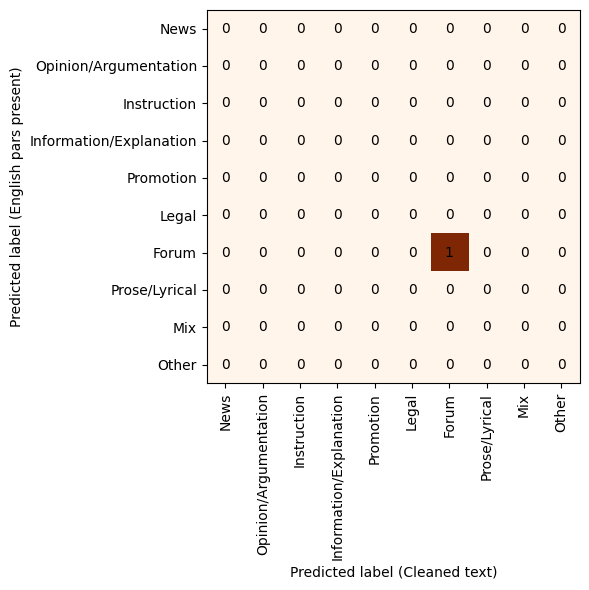

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix with previous y_pred and new y_pred
LABELS = ['News', 'Opinion/Argumentation', 'Instruction', 'Information/Explanation', 'Promotion', 'Legal', 'Forum', 'Prose/Lyrical', "Mix", "Other"]
cm = confusion_matrix(test_df[test_df["changed_text"] != "same"]["y_pred"].to_list(), test_df[test_df["changed_text"] != "same"]["new_pred"].to_list(), labels=LABELS)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Oranges")
for (i, j), z in np.ndenumerate(cm):
	plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
classNames = LABELS
plt.ylabel('Predicted label (English pars present)')
plt.xlabel('Predicted label (Cleaned text)')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=90)
plt.yticks(tick_marks, classNames)

plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()

Let's now clean the test sample. 

In [29]:
# If the y_pred is not the same genre anymore or was removed, remove this instance (to keep 10 instances per genre) - we will need to add instances to the sample

test_df = test_df[(test_df['y_pred'] == test_df['new_pred']) | (test_df['new_pred'] == 'same')]

print(test_df.shape)

test_df[test_df["new_pred"] != "same"][["y_pred", "y_true", "new_pred"]]

(80, 12)


,y_pred,y_true,new_pred
23,Promotion,Promotion,Promotion
67,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation


In [9]:
# For the changed texts where the prediction remained the same, change this text with new text
test_df["text"] = np.where(test_df["new_pred"] != "same", test_df["changed_text"], test_df["text"])

# Add to these texts "to-check" label
test_df["check"] = np.where(test_df["new_pred"] != "same", "yes", "no")

display(test_df[test_df["new_pred"] != "same"].head(2))
test_df.head(2)

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred,check
25,macocu.uk.8392165,Forum,Повідомлень 5 <p>Тема: Підголовники <p>Хто ска...,Messages 5\n\nTopic: heads\n\nWho will tell if...,{'text_id': 'macocu.uk.8392165'},Forum,"[▁По, від, ом, лень, ▁5, ▁Тема, :, ▁Під, голов...","[901, 11009, 419, 54990, 190, 55718, 12, 20434...",Povidomlen' 5 \n\nTema: Pidholovnyky \n\nXto s...,povidomlen' 5 \n\ntema: pidgolovniki \n\nkhto ...,"[▁po, vido, m, len, ', ▁5, ▁tema, :, ▁, pid, g...",Повідомлень 5 <p>Тема: Підголовники <p>Хто ска...,Forum,yes


,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred,check
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ...",same,same,no
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical,"[▁М, УЧ, ЕНИ, КИ, ▁, БУ, ЧА, -, ІР, П, ІН, Ь, ...","[1435, 87706, 78591, 38682, 6, 39932, 75333, 9...",MUČENYKY BUČA-IRPIN' \n\nNe snylos' poljanam j...,mucheniki bucha-irpin' \n\nne snilos' polianam...,"[▁much, e, niki, ▁bu, cha, -, ir, pin, ', ▁ne,...",same,same,no


Add additional instances to the sample

In [17]:
# Remove from the sample instance "macocu.tr.450690" which is now "multiple texts" - case of turkish
test_df = test_df[test_df["text_id"] != "macocu.tr.450690"]

test_df.shape

(79, 13)

In [18]:
label_count_dict = test_df["y_pred"].value_counts().to_dict()

# Calculate how many texts are missing
label_missing_count = {}

for item in list(label_count_dict.items()):
	if item[1] != 10:
		label_missing_count[item[0]] = int(10-item[1])

label_missing_count

{'Instruction': 1}

In [19]:
# Get information about text ids so that we won't extract the same id
text_ids = test_df["text_id"].to_list()

# We will extract all labels that are missing, except Mix and Other
labels_list = list(label_missing_count.keys())

# First create the initial main_df to which all others in the loop will be added
final_sample = main_df[main_df["genre"] == labels_list[0]].sample(n=label_missing_count[labels_list[0]])

# Add all other domains
remaining_list = labels_list[1:]

for i in remaining_list:
	try:
		added_instances = main_df[main_df["genre"] == i].sample(n=label_missing_count[i])
		final_sample = pd.concat([final_sample, added_instances])
	except:
		print(main_df[main_df["genre"] == i][:2].to_markdown())

# Check whether any of the text ids are duplicated
new_text_ids = final_sample["document_id"].to_list()

combined_list = new_text_ids + text_ids
if len(combined_list) == len(set(combined_list)):
	print("No duplicated texts.")
else:
	print("There are duplicated texts, repeat the process.")

# Shuffle rows
final_sample = final_sample.sample(frac=1)

# Rename the document_id to text_id
final_sample = final_sample.rename(columns={"document_id":"text_id", "genre":"y_pred"})

# Drop all unrelevant columns
final_sample = final_sample.drop(columns=["logit", "lang_distr", "lang", "text_length"])

# Add column "check"
final_sample["check"] = "yes"

final_sample

No duplicated texts.


,text_id,text,y_pred,check
10213010,macocu.tr.15896127,o Bir dünya çiziyorsunuz içi boş. Bu Ali'nin d...,Instruction,yes


In [20]:
# Now, merge the final_sample with the test_df
test_df = pd.concat((test_df,final_sample))

test_df.tail(3)

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_norm,tokens_norm,changed_text,new_pred,check
83,macocu.tr.5771013,News,"Brent petrolün varili, uluslararası piyasalard...",Brent oil is trading for $ 58.87 in internatio...,{'text_id': 'macocu.tr.5771013'},News,"[▁Brent, ▁petrol, ün, ▁var, ili, ,, ▁uluslarar...","[192050, 42628, 7640, 285, 2104, 4, 103822, 75...","brent petrolun varili, uluslararasi piyasalard...","[▁bre, nt, ▁petrol, un, ▁var, ili, ,, ▁, ulus,...",same,same,no
84,macocu.tr.9017602,Promotion,Firma Etiketleri \n\nFirma Açıklaması \n\nSekt...,Company labels\n\nCompany Description\n\nWith ...,{'text_id': 'macocu.tr.9017602'},Promotion,"[▁Firma, ▁Etiketler, i, ▁Firma, ▁Açıklama, sı,...","[19989, 79067, 14, 19989, 217307, 2540, 503, 8...",firma etiketleri \n\nfirma aciklamasi \n\nsekt...,"[▁firma, ▁etiket, leri, ▁firma, ▁a, ci, klama,...",same,same,no
10213010,macocu.tr.15896127,Instruction,o Bir dünya çiziyorsunuz içi boş. Bu Ali'nin d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes


In [10]:
# Split the test df into okay instances and instances that need to be checked
ok_df = test_df[test_df["check"] == "no"]
print(ok_df.shape)
ok_df.head(2)

(79, 14)


,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred,check
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ...",same,same,no
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical,"[▁М, УЧ, ЕНИ, КИ, ▁, БУ, ЧА, -, ІР, П, ІН, Ь, ...","[1435, 87706, 78591, 38682, 6, 39932, 75333, 9...",MUČENYKY BUČA-IRPIN' \n\nNe snylos' poljanam j...,mucheniki bucha-irpin' \n\nne snilos' polianam...,"[▁much, e, niki, ▁bu, cha, -, ir, pin, ', ▁ne,...",same,same,no


In [11]:
# Part that needs checking
check_df = test_df[test_df["check"] == "yes"]

# Change <p> signs to actual new lines
check_df["text"] = check_df["text"].str.replace("<p>", "\n\n")


check_df

/tmp/ipykernel_585884/2386379935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df["text"] = check_df["text"].str.replace("<p>", "\n\n")


,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred,check
25,macocu.uk.8392165,Forum,Повідомлень 5 \n\nТема: Підголовники \n\nХто с...,Messages 5\n\nTopic: heads\n\nWho will tell if...,{'text_id': 'macocu.uk.8392165'},Forum,"[▁По, від, ом, лень, ▁5, ▁Тема, :, ▁Під, голов...","[901, 11009, 419, 54990, 190, 55718, 12, 20434...",Povidomlen' 5 \n\nTema: Pidholovnyky \n\nXto s...,povidomlen' 5 \n\ntema: pidgolovniki \n\nkhto ...,"[▁po, vido, m, len, ', ▁5, ▁tema, :, ▁, pid, g...",Повідомлень 5 <p>Тема: Підголовники <p>Хто ска...,Forum,yes


In [12]:
# Now, translate the sentences of the instances that need to be checked
sentence_list = check_df["text"].to_list()

import googletrans
from googletrans import Translator

# Apply Google Translate and machine translate the data - documentation: https://py-googletrans.readthedocs.io/en/latest/

# Define the translation model
translator = Translator()

# Create the final list
translation_GT = []

source_lang = suffix.split("-")[0]

print("Starting translation.")

# The suffix that GT uses for all languages is the same as the suffix used in the dataset names, except for Montenegrin
# GT does not have a special model for Montenegrin, so we will use the Serbian model
if source_lang == "cnr":
	lang = "sr"
else:
	lang = source_lang

# Loop through the list of original sentences,
# translate each and append the translation to the final list
for i in sentence_list:
	# Translate the sentence from source language, e.g. Slovene (src = "sl") to English (dest = "en")
		current_translation = translator.translate(i, src = lang, dest='en')
	# Append the translated sentence to the final list
		translation_GT.append(current_translation.text)

print("Translation finished.")

# Append translations to the sample

check_df["translation"] = translation_GT

Starting translation.
Translation finished.


/tmp/ipykernel_585884/376183009.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df["translation"] = translation_GT


In [13]:
check_df.shape

(1, 14)

In [14]:
# Manually check the instances
with pd.option_context('display.max_colwidth', None):
	display(check_df[["y_pred", "translation"]])


,y_pred,translation
25,Forum,"Messages 5\n\nTopic: heads\n\nWho will tell if you can replace the front (s) in the machine?I want an adjustable tilt header, because with the regular I see only the ceiling if I rest on it.Can some other model fit?\n\nBetter at the 7th at home on Logan 1.6 Laureate than in 6th in the morgue ...\n\nRe: heads\n\nI thought the same thing, but the drivers say that they are to be drawn on something on something by the driver's head-""Moveton"".That is, a flat ""hanging"" head subtly feels all spatial evolutions and acceleration of the car and decides on compensatory management.Hirascope, hook ... And you want to put a gyroscope in the header ...\n\nRe: heads\n\nAs far as I know, they are intended to protect the neck when struck in the car from the back, not for the rest of the neck - are I not right?\n\nRe: heads\n\nMekena wrote:\n\n0\n\nMessages 5"


In [21]:
print(LABELS)

['News', 'Opinion/Argumentation', 'Instruction', 'Information/Explanation', 'Promotion', 'Legal', 'Forum', 'Prose/Lyrical', 'Mix', 'Other']


In [15]:
# Add manually assigned labels
evaluated_labels = ['Forum']
check_df["y_true"] = evaluated_labels
check_df

/tmp/ipykernel_585884/2057022069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df["y_true"] = evaluated_labels


,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm,changed_text,new_pred,check
25,macocu.uk.8392165,Forum,Повідомлень 5 \n\nТема: Підголовники \n\nХто с...,Messages 5\n\nTopic: heads\n\nWho will tell if...,{'text_id': 'macocu.uk.8392165'},Forum,"[▁По, від, ом, лень, ▁5, ▁Тема, :, ▁Під, голов...","[901, 11009, 419, 54990, 190, 55718, 12, 20434...",Povidomlen' 5 \n\nTema: Pidholovnyky \n\nXto s...,povidomlen' 5 \n\ntema: pidgolovniki \n\nkhto ...,"[▁po, vido, m, len, ', ▁5, ▁tema, :, ▁, pid, g...",Повідомлень 5 <p>Тема: Підголовники <p>Хто ска...,Forum,yes


In [14]:
# In case of EL, there were no changes needed
#final_test_df = test_df
# Reset the index
#final_test_df.reset_index(drop=True, inplace=True)

# Remove unnecessary columns
#final_test_df = final_test_df.drop(columns=["changed_text", "new_pred"])
#final_test_df.tail(1)

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm
79,macocu.el.8242911,News,Φυσικό αέριο: Πιθανόν εντός της ημέρας το ρωσι...,Natural Gas: Probably within the day the Russi...,{'text_id': 'macocu.el.8242911'},News,"[▁Φυσικ, ό, ▁α, έρι, ο, :, ▁Π, ι, θαν, όν, ▁εν...","[212156, 1279, 5961, 116278, 1457, 12, 4839, 1...",Fusiko aerio: Pithanon entos tis imeras to ros...,phusiko aerio: pithanon entos tes emeras to ro...,"[▁phu, siko, ▁a, er, io, :, ▁pit, han, on, ▁en..."


In [16]:
# Now, merge the two splits back together
final_test_df = pd.concat((ok_df, check_df))

# Reset the index
final_test_df.reset_index(drop=True, inplace=True)

# Remove unnecessary columns
final_test_df = final_test_df.drop(columns=["changed_text", "new_pred", "check"])

final_test_df

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ..."
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical,"[▁М, УЧ, ЕНИ, КИ, ▁, БУ, ЧА, -, ІР, П, ІН, Ь, ...","[1435, 87706, 78591, 38682, 6, 39932, 75333, 9...",MUČENYKY BUČA-IRPIN' \n\nNe snylos' poljanam j...,mucheniki bucha-irpin' \n\nne snilos' polianam...,"[▁much, e, niki, ▁bu, cha, -, ir, pin, ', ▁ne,..."
2,macocu.uk.8192353,Forum,------ Що ж читаєм молитву ще .......9 Ви ж мо...,------ What we read the prayer yet ....... 9 Y...,{'text_id': 'macocu.uk.8192353'},Forum,"[▁, ------, ▁Що, ▁ж, ▁чита, єм, ▁молитв, у, ▁щ...","[6, 110405, 21565, 2637, 16911, 24032, 103374,...",------ Ščo ž čytajem molytvu šče .......9 Vy ž...,------ shcho zh chitaiem molitvu shche ..........,"[▁, ------, ▁sh, cho, ▁z, h, ▁chi, ta, iem, ▁m..."
3,macocu.uk.14283095,Promotion,Круглий стіл «Корпоративна соціальна відповіда...,"Round table ""Corporate social responsibility o...",{'text_id': 'macocu.uk.14283095'},Promotion,"[▁Кру, гли, й, ▁стіл, ▁«, Кор, пор, ативна, ▁с...","[61797, 29034, 312, 199472, 94, 110879, 28551,...",Kruhlyj stil «Korporatyvna social'na vidpovida...,kruglii stil <<korporativna sotsial'na vidpovi...,"[▁krug, li, i, ▁stil, ▁<<, korpora, tiv, na, ▁..."
4,macocu.uk.13245909,Legal,"Про визнання майнових прав, права власності на...","On recognition of property rights, ownership o...",{'text_id': 'macocu.uk.13245909'},Legal,"[▁Про, ▁визнання, ▁майно, вих, ▁прав, ,, ▁прав...","[2443, 192396, 129232, 31493, 5999, 4, 2868, 7...","Pro vyznannja majnovyx prav, prava vlasnosti n...","pro viznannia mainovikh prav, prava vlasnosti ...","[▁pro, ▁viz, nan, nia, ▁mai, nov, ikh, ▁prav, ..."
...,...,...,...,...,...,...,...,...,...,...,...
75,macocu.uk.3331806,Prose/Lyrical,КАРПАТЬСЬКИЙ ВАЛЬС \n\n* \n\nКАРПАТЬСЬКИЙ ВАЛЬ...,Karpat Waltz\n\n*\n\nKarpat Waltz mus.J. Korot...,{'text_id': 'macocu.uk.3331806'},Prose/Lyrical,"[▁КАР, ПА, ТЬ, СЬ, К, ИЙ, ▁В, АЛЬ, С, ▁*, ▁КАР...","[179127, 48545, 99852, 134307, 2426, 65837, 41...",KARPAT'S'KYJ VAL'S \n\n* \n\nKARPAT'S'KYJ VAL'...,karpat's'kii val's \n\n* \n\nkarpat's'kii val'...,"[▁kar, pat, ', s, ', kii, ▁val, ', s, ▁*, ▁kar..."
76,macocu.uk.5066274,News,Сьогодні перший заступник голови Львівської ОД...,"Today, the first deputy chairman of the Lviv R...",{'text_id': 'macocu.uk.5066274'},News,"[▁Сьогодні, ▁перший, ▁заступник, ▁голови, ▁Льв...","[77870, 68486, 62911, 50846, 177856, 6, 107674...",S'ohodni peršyj zastupnyk holovy L'vivs'koï OD...,s'ogodni pershii zastupnik golovi l'vivs'koyi ...,"[▁s, ', o, god, ni, ▁per, shi, i, ▁zastupnik, ..."
77,macocu.uk.20665684,Information/Explanation,Більшість наших сучасників вважає що не вимага...,Most of our contemporaries believe that it doe...,{'text_id': 'macocu.uk.20665684'},Information/Explanation,"[▁Більшість, ▁наших, ▁с, учасник, ів, ▁вважає,...","[226784, 23070, 135, 89116, 790, 116211, 899, ...",Bil'šist' našyx sučasnykiv vvažaje ščo ne vyma...,bil'shist' nashikh suchasnikiv vvazhaie shcho ...,"[▁bil, ', s, hist, ', ▁na, shik, h, ▁such, as,..."
78,macocu.uk.15399954,News,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},News,"[▁Антон, ▁Гер, а, щенко, :, ▁Справ, а, ▁"", Стр...","[41867, 41287, 59, 142773, 12, 113083, 59, 44,...","Anton Heraščenko: Sprava ""Strany.ua"" ta Ihorja...","anton gerashchenko: sprava ""strani.ua"" ta

## Analyse final test dataset

In [17]:
final_test_df["y_pred"].value_counts()

y_pred
Instruction                10
Prose/Lyrical              10
Forum                      10
Promotion                  10
Legal                      10
News                       10
Opinion/Argumentation      10
Information/Explanation    10
Name: count, dtype: int64

Macro f1: 0.948, Micro f1: 0.95
Accuracy: 0.95


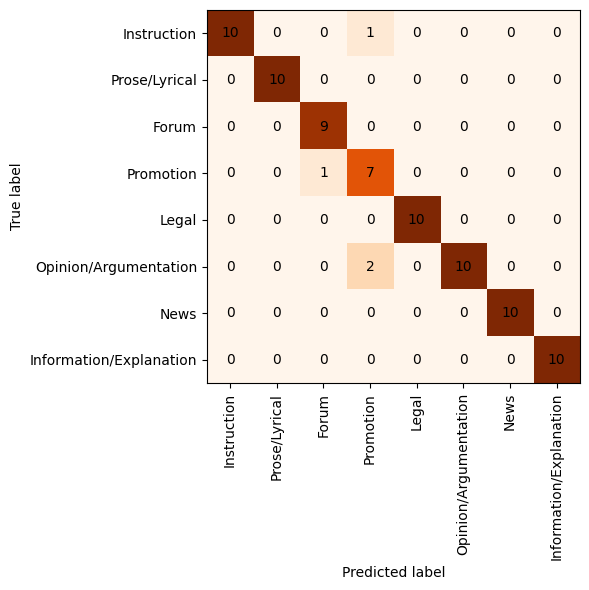

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |     0.9     | 1        |   0.947368 |      9    |
| Information/Explanation |     1       | 1        |   1        |     10    |
| Instruction             |     1       | 0.909091 |   0.952381 |     11    |
| Legal                   |     1       | 1        |   1        |     10    |
| News                    |     1       | 1        |   1        |     10    |
| Opinion/Argumentation   |     1       | 0.833333 |   0.909091 |     12    |
| Promotion               |     0.7     | 0.875    |   0.777778 |      8    |
| Prose/Lyrical           |     1       | 1        |   1        |     10    |
| accuracy                |     0.95    | 0.95     |   0.95     |      0.95 |
| macro avg               |     0.95    | 0.952178 |   0.948327 |     80    |
| weighted avg            |     0.95875 | 0.95     |   0.951673 

<Figure size 640x480 with 0 Axes>

In [18]:
y_pred = final_test_df["y_pred"].to_list()
y_true = final_test_df["y_true"].to_list()
labels = list(final_test_df["y_true"].unique())

results = testing(y_true, y_pred, labels)

In [19]:
# Let's update the values of the dictionary
print(main_dict[lang].keys())

label_scores = {}

for label in labels:
	label_scores[label] = results["report"][label]["f1-score"]

# Add new language results
main_dict[lang] = {"accuracy": results["accuracy"], "micro_f1": results['micro F1'], "macro_f1": results['macro F1'], "label_scores": label_scores, "dataset": final_test_df.to_dict()}

print(main_dict[lang].keys())

dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'dataset', 'token_overlap'])
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])


In [20]:
pd.DataFrame(main_dict[lang]["dataset"])

,text_id,y_pred,text,translation,metadata,y_true,tokens,token_ids,text_latin,text_norm,tokens_norm
0,macocu.uk.419381,Instruction,Нестандартний підхід для виготовлення Акваріум...,A non -standard approach for making aquarium.O...,{'text_id': 'macocu.uk.419381'},Instruction,"[▁Не, стандарт, ний, ▁підхід, ▁для, ▁виготовле...","[1087, 159257, 1394, 205827, 518, 166156, 1307...",Nestandartnyj pidxid dlja vyhotovlennja Akvari...,nestandartnii pidkhid dlia vigotovlennia akvar...,"[▁nesta, ndar, tni, i, ▁pi, dk, hid, ▁d, lia, ..."
1,macocu.uk.16993168,Prose/Lyrical,МУЧЕНИКИ БУЧА-ІРПІНЬ \n\nНе снилось полянам й ...,The martyrs of Bucha-Irpin\n\nThe glades and t...,{'text_id': 'macocu.uk.16993168'},Prose/Lyrical,"[▁М, УЧ, ЕНИ, КИ, ▁, БУ, ЧА, -, ІР, П, ІН, Ь, ...","[1435, 87706, 78591, 38682, 6, 39932, 75333, 9...",MUČENYKY BUČA-IRPIN' \n\nNe snylos' poljanam j...,mucheniki bucha-irpin' \n\nne snilos' polianam...,"[▁much, e, niki, ▁bu, cha, -, ir, pin, ', ▁ne,..."
2,macocu.uk.8192353,Forum,------ Що ж читаєм молитву ще .......9 Ви ж мо...,------ What we read the prayer yet ....... 9 Y...,{'text_id': 'macocu.uk.8192353'},Forum,"[▁, ------, ▁Що, ▁ж, ▁чита, єм, ▁молитв, у, ▁щ...","[6, 110405, 21565, 2637, 16911, 24032, 103374,...",------ Ščo ž čytajem molytvu šče .......9 Vy ž...,------ shcho zh chitaiem molitvu shche ..........,"[▁, ------, ▁sh, cho, ▁z, h, ▁chi, ta, iem, ▁m..."
3,macocu.uk.14283095,Promotion,Круглий стіл «Корпоративна соціальна відповіда...,"Round table ""Corporate social responsibility o...",{'text_id': 'macocu.uk.14283095'},Promotion,"[▁Кру, гли, й, ▁стіл, ▁«, Кор, пор, ативна, ▁с...","[61797, 29034, 312, 199472, 94, 110879, 28551,...",Kruhlyj stil «Korporatyvna social'na vidpovida...,kruglii stil <<korporativna sotsial'na vidpovi...,"[▁krug, li, i, ▁stil, ▁<<, korpora, tiv, na, ▁..."
4,macocu.uk.13245909,Legal,"Про визнання майнових прав, права власності на...","On recognition of property rights, ownership o...",{'text_id': 'macocu.uk.13245909'},Legal,"[▁Про, ▁визнання, ▁майно, вих, ▁прав, ,, ▁прав...","[2443, 192396, 129232, 31493, 5999, 4, 2868, 7...","Pro vyznannja majnovyx prav, prava vlasnosti n...","pro viznannia mainovikh prav, prava vlasnosti ...","[▁pro, ▁viz, nan, nia, ▁mai, nov, ikh, ▁prav, ..."
...,...,...,...,...,...,...,...,...,...,...,...
75,macocu.uk.3331806,Prose/Lyrical,КАРПАТЬСЬКИЙ ВАЛЬС \n\n* \n\nКАРПАТЬСЬКИЙ ВАЛЬ...,Karpat Waltz\n\n*\n\nKarpat Waltz mus.J. Korot...,{'text_id': 'macocu.uk.3331806'},Prose/Lyrical,"[▁КАР, ПА, ТЬ, СЬ, К, ИЙ, ▁В, АЛЬ, С, ▁*, ▁КАР...","[179127, 48545, 99852, 134307, 2426, 65837, 41...",KARPAT'S'KYJ VAL'S \n\n* \n\nKARPAT'S'KYJ VAL'...,karpat's'kii val's \n\n* \n\nkarpat's'kii val'...,"[▁kar, pat, ', s, ', kii, ▁val, ', s, ▁*, ▁kar..."
76,macocu.uk.5066274,News,Сьогодні перший заступник голови Львівської ОД...,"Today, the first deputy chairman of the Lviv R...",{'text_id': 'macocu.uk.5066274'},News,"[▁Сьогодні, ▁перший, ▁заступник, ▁голови, ▁Льв...","[77870, 68486, 62911, 50846, 177856, 6, 107674...",S'ohodni peršyj zastupnyk holovy L'vivs'koï OD...,s'ogodni pershii zastupnik golovi l'vivs'koyi ...,"[▁s, ', o, god, ni, ▁per, shi, i, ▁zastupnik, ..."
77,macocu.uk.20665684,Information/Explanation,Більшість наших сучасників вважає що не вимага...,Most of our contemporaries believe that it doe...,{'text_id': 'macocu.uk.20665684'},Information/Explanation,"[▁Більшість, ▁наших, ▁с, учасник, ів, ▁вважає,...","[226784, 23070, 135, 89116, 790, 116211, 899, ...",Bil'šist' našyx sučasnykiv vvažaje ščo ne vyma...,bil'shist' nashikh suchasnikiv vvazhaie shcho ...,"[▁bil, ', s, hist, ', ▁na, shik, h, ▁such, as,..."
78,macocu.uk.15399954,News,"Антон Геращенко: Справа ""Страни.ua"" та Ігоря Г...","Anton Gerashchenko: Case ""Stran.ua"" and Igor G...",{'text_id': 'macocu.uk.15399954'},News,"[▁Антон, ▁Гер, а, щенко, :, ▁Справ, а, ▁"", Стр...","[41867, 41287, 59, 142773, 12, 113083, 59, 44,...","Anton Heraščenko: Sprava ""Strany.ua"" ta Ihorja...","anton gerashchenko: sprava ""strani.ua"" ta

In [21]:
with open("manual-annotations/multilingual-genre-annotated-test-set.json", "w") as file:
	json.dump(main_dict, file)

In [22]:
# Now, also clean from the main dict all information that need to be repeated on newly prepared texts so that we do not have a mess

In [78]:
with open("manual-annotations/multilingual-genre-annotated-test-set.json", "r") as file:
	main_dict = json.load(file)

In [79]:
main_dict.keys()

dict_keys(['mt', 'el', 'tr', 'sq', 'is', 'uk', 'ca', 'mk', 'hr', 'sl'])

In [93]:
for lang in list(main_dict.keys()):
	print(lang)
	print(main_dict[lang].keys())

mt
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
el
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
tr
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
sq
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
is
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
uk
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
ca
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
mk
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
hr
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])
sl
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])


clean datasets

In [80]:
lang = "sl"
df = pd.DataFrame(main_dict[lang]["dataset"])
df.head(2)

,text_id,y_pred,text,translation,metadata,y_true
1,CLASSLA-web.sl.1087171,Opinion/Argumentation,Kitajsko mesto duhov\nV Notranji Mongoliji ras...,The Chinese ghost city in Inner Mongolia is gr...,"CLASSLA-web.sl.1087171', 'domain': 'mladina.si'}",News
2,CLASSLA-web.sl.1215246,Instruction,"Krompir skuhamo, olupimo in narežemo na tanke ...","Cook the potatoes, peel and cut into thin ring...","CLASSLA-web.sl.1215246', 'domain': 'emorje.com'}",Instruction


In [74]:
df = df.drop(columns=['tokens', 'token_ids', 'text_norm', 'tokens_norm'])
df.head(2)

,text_id,y_pred,text,translation,metadata,y_true
1,CLASSLA-web.sl.1087171,Opinion/Argumentation,Kitajsko mesto duhov\nV Notranji Mongoliji ras...,The Chinese ghost city in Inner Mongolia is gr...,"CLASSLA-web.sl.1087171', 'domain': 'mladina.si'}",News
2,CLASSLA-web.sl.1215246,Instruction,"Krompir skuhamo, olupimo in narežemo na tanke ...","Cook the potatoes, peel and cut into thin ring...","CLASSLA-web.sl.1215246', 'domain': 'emorje.com'}",Instruction


In [75]:
# Update the dataset

main_dict[lang]["dataset"] = df.to_dict()

In [76]:
pd.DataFrame(main_dict[lang]["dataset"]).head(2)

,text_id,y_pred,text,translation,metadata,y_true
1,CLASSLA-web.sl.1087171,Opinion/Argumentation,Kitajsko mesto duhov\nV Notranji Mongoliji ras...,The Chinese ghost city in Inner Mongolia is gr...,"CLASSLA-web.sl.1087171', 'domain': 'mladina.si'}",News
2,CLASSLA-web.sl.1215246,Instruction,"Krompir skuhamo, olupimo in narežemo na tanke ...","Cook the potatoes, peel and cut into thin ring...","CLASSLA-web.sl.1215246', 'domain': 'emorje.com'}",Instruction


clean results that need to be repeated also for hr, sl and mk + add label_scores

Macro f1: 0.923, Micro f1: 0.925
Accuracy: 0.925


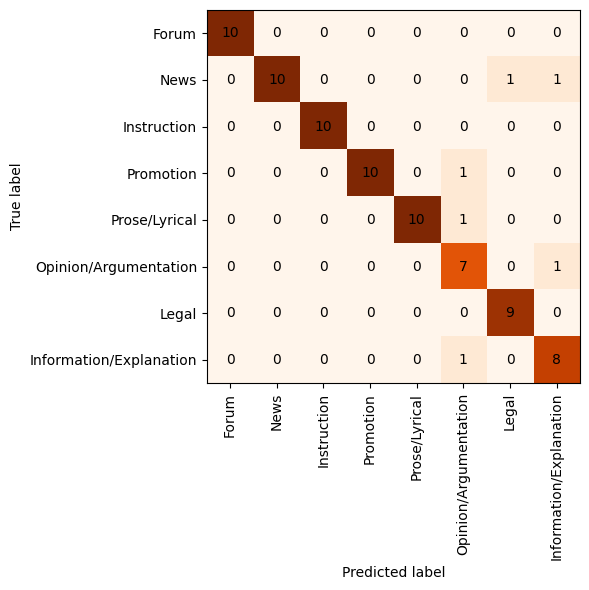

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |     1       | 1        |   1        |    10     |
| Information/Explanation |     0.8     | 0.888889 |   0.842105 |     9     |
| Instruction             |     1       | 1        |   1        |    10     |
| Legal                   |     0.9     | 1        |   0.947368 |     9     |
| News                    |     1       | 0.833333 |   0.909091 |    12     |
| Opinion/Argumentation   |     0.7     | 0.875    |   0.777778 |     8     |
| Promotion               |     1       | 0.909091 |   0.952381 |    11     |
| Prose/Lyrical           |     1       | 0.909091 |   0.952381 |    11     |
| accuracy                |     0.925   | 0.925    |   0.925    |     0.925 |
| macro avg               |     0.925   | 0.926926 |   0.922638 |    80     |
| weighted avg            |     0.93625 | 0.925    |   0.927362 

<Figure size 640x480 with 0 Axes>

In [90]:
lang = "mk"
df = pd.DataFrame(main_dict[lang]["dataset"])

y_pred = df["y_pred"].to_list()
y_true = df["y_true"].to_list()
labels = list(df["y_true"].unique())

results = testing(y_true, y_pred, labels)

In [91]:
# Let's update the values of the dictionary
print(main_dict[lang].keys())

label_scores = {}

for label in labels:
	label_scores[label] = results["report"][label]["f1-score"]

# Add new language results
main_dict[lang] = {"accuracy": results["accuracy"], "micro_f1": results['micro F1'], "macro_f1": results['macro F1'], "label_scores": label_scores, "dataset": df.to_dict()}

print(main_dict[lang].keys())

dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'dataset', 'token_overlap'])
dict_keys(['accuracy', 'micro_f1', 'macro_f1', 'label_scores', 'dataset'])


In [92]:
print(main_dict[lang]["macro_f1"])
pd.DataFrame(main_dict[lang]["dataset"]).head(2)

0.9226380344801398


,text_id,y_pred,text,translation,metadata,y_true
0,CLASSLA-web.mk.1000486,Forum,"Екшули, TCL ги прави смартфоновите, а TCL е см...","Ekshui, TCL makes smartphones, and TCL is hous...","CLASSLA-web.mk.1000486', 'domain': 'forum.carc...",Forum
1,CLASSLA-web.mk.1009071,News,Red Valentino прогнозира бура од принтови за с...,Red Valentino predicts a storm of prints for n...,"CLASSLA-web.mk.1009071', 'domain': 'fashionel....",News


In [94]:
# Save the cleaned dict
with open("manual-annotations/multilingual-genre-annotated-test-set.json", "w") as file:
	json.dump(main_dict, file)